In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("data/transactions_mock_1000_for_participants.csv")

<h3> Data Understanding

In [2]:

# Basic overview
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes.value_counts())
print("\nMissing values (%):\n", df.isna().mean().sort_values(ascending=False).head(15))


# Convert datetime columns
datetime_cols = ["booking_datetime", "value_date", "kyc_last_completed", 
                 "kyc_due_date", "suspicion_determined_datetime", "str_filed_datetime"]
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

df.head()

Shape: (1000, 54)

Data types:
 object     34
bool       14
float64     4
int64       2
Name: count, dtype: int64

Missing values (%):
 str_filed_datetime               0.925
suspicion_determined_datetime    0.925
fx_counterparty                  0.851
fx_quote_ccy                     0.851
fx_base_ccy                      0.851
ordering_institution_bic         0.835
swift_f71_charges                0.835
swift_f70_purpose                0.835
beneficiary_institution_bic      0.835
swift_mt                         0.752
suitability_assessed             0.000
cash_id_verified                 0.000
sanctions_screening              0.000
customer_is_pep                  0.000
kyc_last_completed               0.000
dtype: float64


/var/folders/r5/14k8s1ss4mg5kd7t8s72p6yw0000gn/T/ipykernel_99050/1526603884.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors="coerce")
/var/folders/r5/14k8s1ss4mg5kd7t8s72p6yw0000gn/T/ipykernel_99050/1526603884.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors="coerce")


,transaction_id,booking_jurisdiction,regulator,booking_datetime,value_date,amount,currency,channel,product_type,originator_name,...,suitability_assessed,suitability_result,product_has_va_exposure,va_disclosure_provided,cash_id_verified,daily_cash_total_customer,daily_cash_txn_count,sanctions_screening,suspicion_determined_datetime,str_filed_datetime
0,ad66338d-b17f-47fc-a966-1b4395351b41,HK,HKMA/SFC,2024-10-10 10:24:43,2024-10-10,590012.92,HKD,RTGS,fx_conversion,Meredith Krueger,...,True,match,False,True,True,0.0,1,potential,NaT,NaT
1,135cef35-c054-46f0-8d8d-daedb7429de4,SG,MAS,2024-02-23 23:56:23,NaT,1319007.62,GBP,SWIFT,fx_conversion,Jennifer Parker,...,True,match,False,True,True,0.0,1,none,NaT,NaT
2,f037efc0-8438-4af3-9f68-959cd9c9dcb2,CH,FINMA,2024-06-26 23:40:37,NaT,233935.30,GBP,FAST (SG),wire_transfer,Nicole Guerra DVM,...,True,match,False,True,True,0.0,1,potential,NaT,NaT
3,f7589c12-dccb-4ae1-8ad3-324db3316a56,HK,HKMA/SFC,2024-05-03 00:08:29,2024-03-05,1778002.31,GBP,SEPA,fx_conversion,Jeremy Williams,...,True,match,False,True,True,0.0,1,none,NaT,NaT
4,66f1c2c5-6585-40e9-9b9d-4ec10c6fdbae,SG,MAS,2024-12-03 13:58:10,2024-03-12,2479099.40,HKD,RTGS,fx_conversion,Mr. John Turner MD,...,True,match,False,True,True,0.0,1,potential,NaT,NaT


In [3]:
print("Non-null suspicion_determined_datetime:", df['suspicion_determined_datetime'].notna().sum()) # Considered true hit
print("Null suspicion_determined_datetime:", df['suspicion_determined_datetime'].isna().sum()) # Considered false hit
print("STR filed count:", df["str_filed_datetime"].notna().sum())
df["is_str"] = df["str_filed_datetime"].notna().astype(int)
df["is_str"].value_counts(normalize=True)

Non-null suspicion_determined_datetime: 75
Null suspicion_determined_datetime: 925
STR filed count: 75


is_str
0    0.925
1    0.075
Name: proportion, dtype: float64

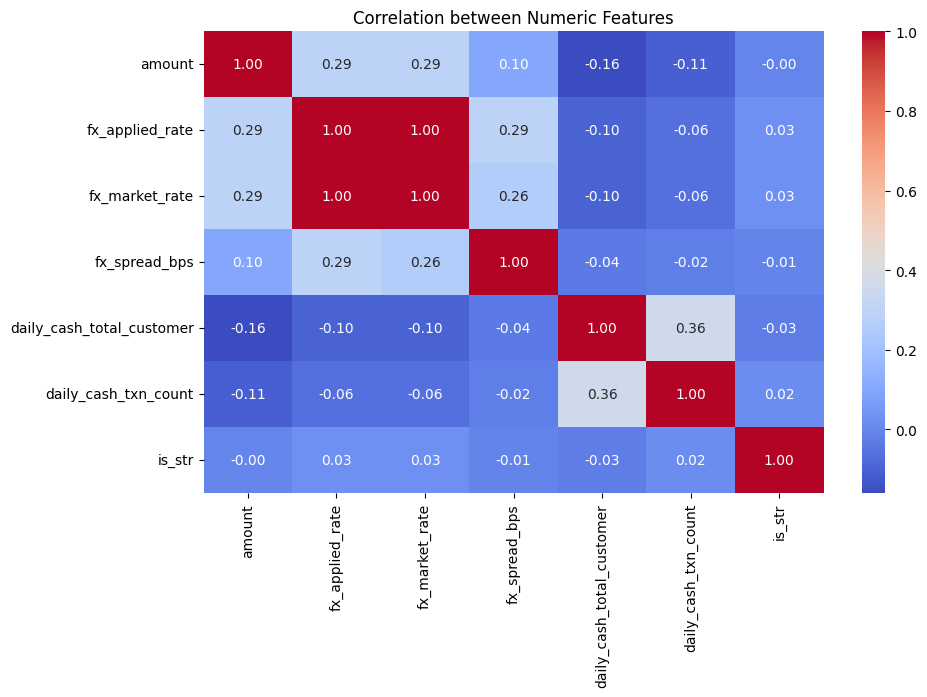

In [4]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between Numeric Features")
plt.show()

fx_applied_rate ↔ fx_market_rate: 1.00
Perfect correlation — they move together exactly.
Likely redundant: one can be dropped or used to create a spread feature.

daily_cash_total_customer ↔ daily_cash_txn_count: 0.36
Intuitive: more transactions usually lead to higher total cash flow.
Suggests you could combine these into a derived feature like
df["avg_cash_txn_size"] = df["daily_cash_total_customer"] / (df["daily_cash_txn_count"] + 1e-6)

In [5]:
# Select categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns

# Summary for top categories
print("\n Categorical Columns Summary:")
for col in ["booking_jurisdiction", "regulator", "currency", "channel", "product_type", 
            "customer_type", "customer_risk_rating", "sanctions_screening"]:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(dropna=False).head(5))


 Categorical Columns Summary:

--- booking_jurisdiction ---
booking_jurisdiction
HK    340
SG    340
CH    320
Name: count, dtype: int64

--- regulator ---
regulator
HKMA/SFC    340
MAS         340
FINMA       320
Name: count, dtype: int64

--- currency ---
currency
CHF    163
USD    133
SGD    125
GBP    123
JPY    122
Name: count, dtype: int64

--- channel ---
channel
Cash         327
FPS (HK)     125
RTGS         122
FAST (SG)    109
SWIFT        107
Name: count, dtype: int64

--- product_type ---
product_type
wire_transfer        239
cash_deposit         202
securities_trade     156
fx_conversion        135
fund_subscription    135
Name: count, dtype: int64

--- customer_type ---
customer_type
domiciliary_company    349
individual             332
corporate              319
Name: count, dtype: int64

--- customer_risk_rating ---
customer_risk_rating
Low       534
Medium    328
High      138
Name: count, dtype: int64

--- sanctions_screening ---
sanctions_screening
potential    539


That confirms a 1:1 mapping between internal suspicion and STR filing.
You can confidently treat is_str as your target variable for supervised modeling.
→ This is highly imbalanced (92.5% normal, 7.5% suspicious) → later, you’ll need techniques like:
RandomUnderSampler / SMOTE

In [6]:
df.groupby("customer_risk_rating")["is_str"].mean()

customer_risk_rating
High      0.072464
Low       0.065543
Medium    0.091463
Name: is_str, dtype: float64

STRs are not purely concentrated in high-risk customers. Combine risk rating with behavioral and transactional variables (e.g., cash usage, cross-border flows) rather than relying solely on KYC ratings. Even medium-risk clients are occasionally triggering suspicious patterns — this may mean:
Risk scoring models are conservative (some “Medium” are behaving like “High”). 

In [7]:
df.groupby("channel")["is_str"].mean().sort_values(ascending=False)

channel
FPS (HK)     0.096000
FAST (SG)    0.091743
Cheque       0.085714
RTGS         0.073770
Cash         0.067278
SEPA         0.066667
SWIFT        0.056075
Name: is_str, dtype: float64

Instant payment channels (FPS, FAST) have the highest STR rates.
→ This is a real-world pattern: faster payment rails are often exploited for mule activity, rapid fund layering, or “smurfing.”
SWIFT transactions, though cross-border, have lowest STR rates, likely because those go through strong KYC and SWIFT message completeness checks (swift_f50_present, swift_f59_present ≈ 99%).

In [8]:
df.groupby("originator_country")["is_str"].mean().nlargest(10)

originator_country
CN    0.194030
TH    0.135593
JP    0.123077
ID    0.105263
AE    0.087719
GB    0.087719
RU    0.084746
HK    0.079365
CH    0.076923
AU    0.062500
Name: is_str, dtype: float64

Originator country is a strong differentiator for STRs — especially China, Thailand, and Japan in your dataset.


 Compliance Flags Summary:
swift_f59_present          0.993
va_disclosure_provided     0.992
suitability_assessed       0.990
sow_documented             0.986
edd_performed              0.969
swift_f50_present          0.946
travel_rule_complete       0.940
cash_id_verified           0.906
edd_required               0.220
product_complex            0.164
fx_indicator               0.149
customer_is_pep            0.096
is_advised                 0.060
product_has_va_exposure    0.033
dtype: float64


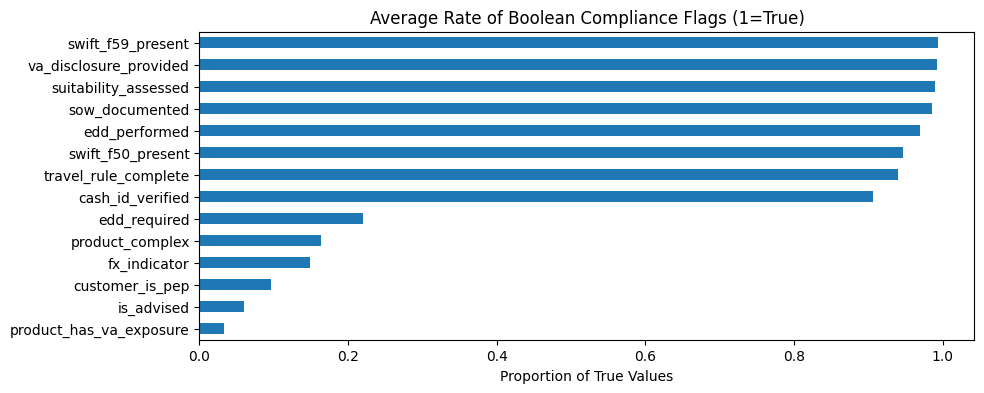

In [9]:
# Select boolean columns
bool_cols = df.select_dtypes(include=["bool"]).columns

# Summary stats for boolean features
print("\n Compliance Flags Summary:")
print(df[bool_cols].mean().sort_values(ascending=False).head(15))

# Visualize proportion of key flags
plt.figure(figsize=(10,4))
df[bool_cols].mean().sort_values().plot(kind="barh")
plt.title("Average Rate of Boolean Compliance Flags (1=True)")
plt.xlabel("Proportion of True Values")
plt.show()


In [10]:
compliance_flags = ['swift_f59_present','travel_rule_complete','edd_performed',
                    'cash_id_verified','customer_is_pep','product_has_va_exposure']

df.groupby('is_str')[compliance_flags].mean().T

is_str,0,1
swift_f59_present,0.992432,1.000000
travel_rule_complete,0.936216,0.986667
edd_performed,0.969730,0.960000
cash_id_verified,0.902703,0.946667
customer_is_pep,0.096216,0.093333
product_has_va_exposure,0.032432,0.040000


/Users/tanyumin/miniconda3/envs/singhacks/lib/python3.11/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


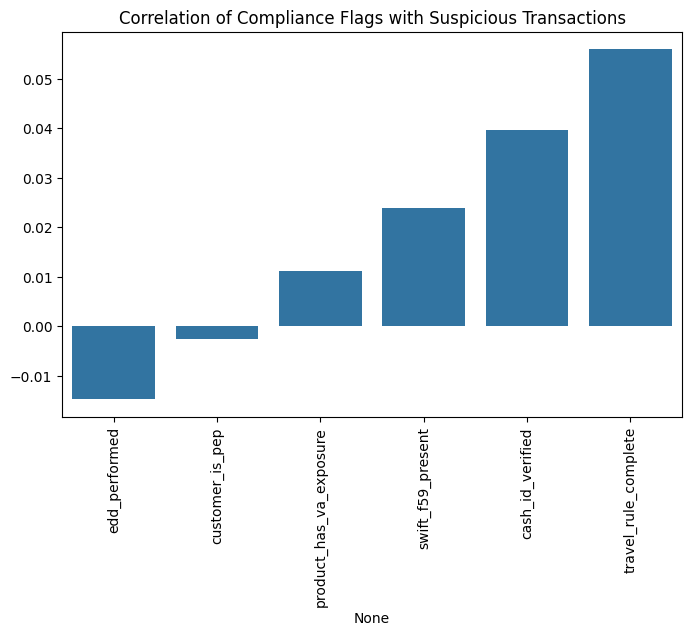

In [11]:
plt.figure(figsize=(8,5))
sns.barplot(x=df[compliance_flags].corrwith(df["is_str"]).sort_values().index,
            y=df[compliance_flags].corrwith(df["is_str"]).sort_values().values)
plt.title("Correlation of Compliance Flags with Suspicious Transactions")
plt.xticks(rotation=90)
plt.show()


Compliance flags alone cannot explain STR filings — models need transactional, temporal, and network features. Travel Rule ≠ Risky — completeness is high in STRs → quality data enables better detection.
EDD oversight — watch for transactions where edd_required=True but edd_performed=False.
Behavior > Paperwork — strong compliance coverage means next EDA should focus on behavioral indicators:
Amount spikes
Cross-border velocity
Repeated counterparties
Country or channel patterns

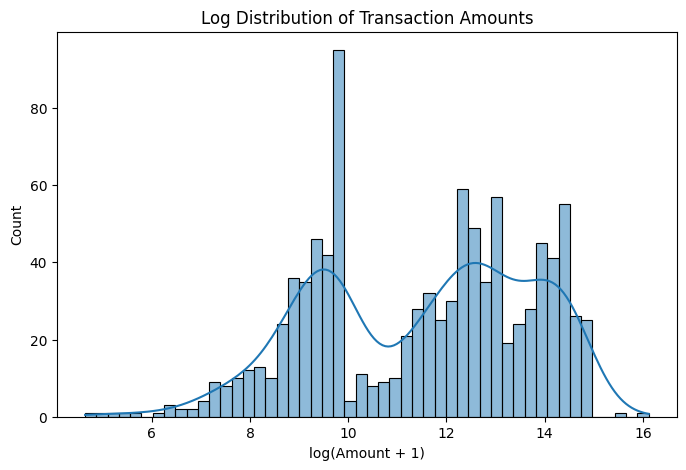

/Users/tanyumin/miniconda3/envs/singhacks/lib/python3.11/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


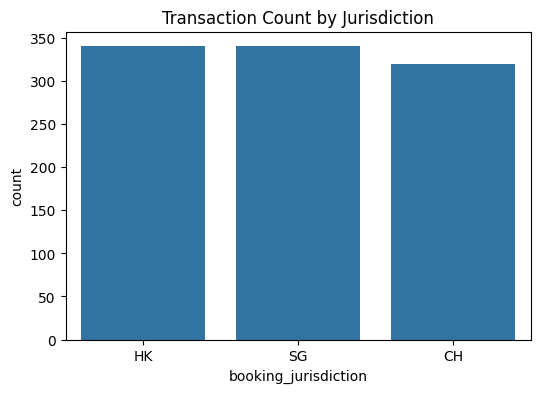

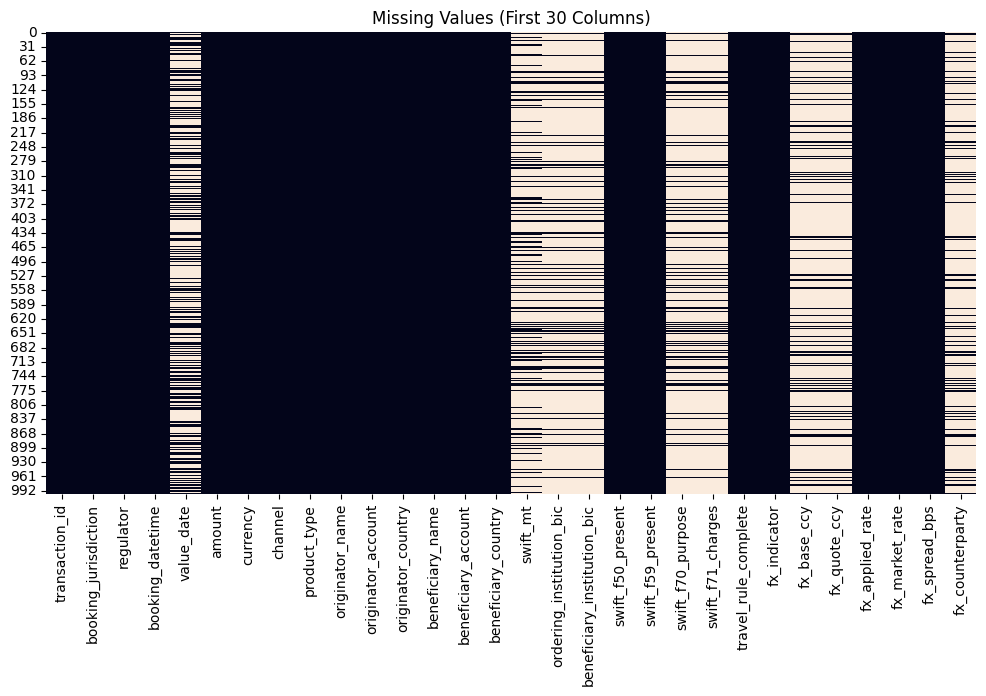

Suspicious transactions (STR filed): 75


In [12]:
# Distribution of transaction amounts
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df["amount"]), bins=50, kde=True)
plt.title("Log Distribution of Transaction Amounts")
plt.xlabel("log(Amount + 1)")
plt.show()

# Transaction count by jurisdiction
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="booking_jurisdiction")
plt.title("Transaction Count by Jurisdiction")
plt.show()

# Missing value heatmap (top 30 columns)
plt.figure(figsize=(12,6))
sns.heatmap(df.isna().iloc[:, :30], cbar=False)
plt.title("Missing Values (First 30 Columns)")
plt.show()

# Count suspicious cases
print("Suspicious transactions (STR filed):", df["str_filed_datetime"].notna().sum())

<h3> Dropping columns


In [13]:
id_cols = [
    "transaction_id", "originator_name", "originator_account",
    "beneficiary_name", "beneficiary_account", "customer_id"
]

missing_cols = [
    "swift_mt", "ordering_institution_bic", "beneficiary_institution_bic",
    "swift_f70_purpose", "swift_f71_charges",
    "fx_base_ccy", "fx_quote_ccy", "fx_counterparty"
]

datetime_cols = [
    "value_date", "kyc_last_completed",
    "kyc_due_date", "suspicion_determined_datetime", "str_filed_datetime" #booking date time 
]

text_cols = ["narrative"]
redundant_cols = ["fx_market_rate"] #fx_applied_rate ≈ fx_market_rate → keep one since they are highly correlated 

drop_cols = (
    id_cols
    + missing_cols
    + datetime_cols
    + text_cols
    + redundant_cols
)

df_cleaned = df.drop(columns=drop_cols, errors='ignore')
print("Cleaned shape:", df_cleaned.shape)

Cleaned shape: (1000, 34)


In [14]:
print(df_cleaned.isna().mean().sort_values(ascending=False).head(10))
print(df_cleaned.dtypes.value_counts())

booking_jurisdiction    0.0
suitability_assessed    0.0
edd_performed           0.0
sow_documented          0.0
purpose_code            0.0
is_advised              0.0
product_complex         0.0
client_risk_profile     0.0
suitability_result      0.0
regulator               0.0
dtype: float64
bool              14
object            13
float64            3
int64              3
datetime64[ns]     1
Name: count, dtype: int64


<h3> Feature Engineering 

In [15]:
# --- Transaction magnitude features ---
df_cleaned["log_amount"] = np.log1p(df_cleaned["amount"])   # Normalize skewed values

# --- Cash structuring indicators ---
df_cleaned["avg_cash_txn_size"] = df_cleaned["daily_cash_total_customer"] / (df_cleaned["daily_cash_txn_count"] + 1e-6)
df_cleaned["cash_txn_ratio"] = df_cleaned["amount"] / (df_cleaned["daily_cash_total_customer"] + 1e-6)
df_cleaned["high_cash_activity"] = (df_cleaned["daily_cash_txn_count"] > 5).astype(int)  # arbitrary threshold

# --- FX anomaly detection ---
df_cleaned["fx_spread_diff"] = abs(df_cleaned["fx_applied_rate"] - df_cleaned["fx_spread_bps"]/10000)  # simplified deviation
df_cleaned["is_fx_txn"] = df_cleaned["fx_indicator"].astype(int)

# --- Risk encoding ---
risk_map = {"Low": 1, "Medium": 2, "High": 3}
df_cleaned["customer_risk_score"] = df_cleaned["customer_risk_rating"].map(risk_map)

# --- EDD gaps ---
df_cleaned["edd_gap"] = ((df_cleaned["edd_required"]) & (~df_cleaned["edd_performed"])).astype(int)

# --- High-risk customer combined flag ---
df_cleaned["high_risk_customer"] = ((df_cleaned["customer_is_pep"]) | (df_cleaned["customer_risk_score"] == 3)).astype(int)

# --- Travel Rule / SWIFT message completeness ---
df_cleaned["swift_missing_ratio"] = (~df_cleaned[["swift_f50_present", "swift_f59_present", "travel_rule_complete"]]).sum(axis=1) / 3

# --- Compliance score (overall adherence) ---
compliance_cols = [
    "swift_f59_present", "swift_f50_present", "travel_rule_complete",
    "edd_performed", "sow_documented", "suitability_assessed", 
    "cash_id_verified", "va_disclosure_provided"
]
df_cleaned["compliance_score"] = df_cleaned[compliance_cols].mean(axis=1)

# --- Jurisdiction risk based on STR rates ---
juris_risk = df_cleaned.groupby("booking_jurisdiction")["is_str"].mean().to_dict()
df_cleaned["jurisdiction_risk"] = df_cleaned["booking_jurisdiction"].map(juris_risk)

# --- Originator country risk based on STR rates ---
country_risk = df_cleaned.groupby("originator_country")["is_str"].mean().to_dict()
df_cleaned["originator_country_risk"] = df_cleaned["originator_country"].map(country_risk)

# --- Cross-border indicator ---
df_cleaned["cross_border_flag"] = (df_cleaned["originator_country"] != df_cleaned["beneficiary_country"]).astype(int)

# --- Risky channel flag ---
instant_channels = ["FPS (HK)", "FAST (SG)"]
df_cleaned["instant_channel_flag"] = df_cleaned["channel"].isin(instant_channels).astype(int)

# --- Product type risk (complexity indicator) ---
risky_products = ["fx_conversion", "securities_trade", "fund_subscription"]
df_cleaned["risky_product_flag"] = df_cleaned["product_type"].isin(risky_products).astype(int)

# --- Combined risk metrics ---
df_cleaned["behavioral_risk_score"] = (
    df_cleaned["is_fx_txn"]
    + df_cleaned["cross_border_flag"]
    + df_cleaned["instant_channel_flag"]
    + df_cleaned["risky_product_flag"]
)

df_cleaned["overall_risk_score"] = (
    df_cleaned["customer_risk_score"]
    + df_cleaned["behavioral_risk_score"]
    + (1 - df_cleaned["compliance_score"]) * 3  # weight missing compliance more heavily
)

engineered_cols = [
    "log_amount", "avg_cash_txn_size", "cash_txn_ratio", "fx_spread_diff", "edd_gap",
    "high_risk_customer", "swift_missing_ratio", "compliance_score",
    "jurisdiction_risk", "originator_country_risk",
    "cross_border_flag", "instant_channel_flag", "risky_product_flag",
    "behavioral_risk_score", "overall_risk_score"
]

print("Added engineered features:", engineered_cols)
print(df_cleaned[engineered_cols + ["is_str"]].head())


Added engineered features: ['log_amount', 'avg_cash_txn_size', 'cash_txn_ratio', 'fx_spread_diff', 'edd_gap', 'high_risk_customer', 'swift_missing_ratio', 'compliance_score', 'jurisdiction_risk', 'originator_country_risk', 'cross_border_flag', 'instant_channel_flag', 'risky_product_flag', 'behavioral_risk_score', 'overall_risk_score']
   log_amount  avg_cash_txn_size  cash_txn_ratio  fx_spread_diff  edd_gap  \
0   13.287901                0.0    5.900129e+11        0.000000        0   
1   14.092391                0.0    1.319008e+12        0.673705        0   
2   12.362804                0.0    2.339353e+11        0.967420        0   
3   14.391002                0.0    1.778002e+12        0.000000        0   
4   14.723406                0.0    2.479099e+12        1.352646        0   

   high_risk_customer  swift_missing_ratio  compliance_score  \
0                   0                  0.0               1.0   
1                   0                  0.0               1.0   
2       

<h3> Encoding

In [16]:
cat_cols = [
    "booking_jurisdiction", "regulator", "currency", 
    "channel", "product_type", 
    "customer_type", "customer_risk_rating", 
    "originator_country", "beneficiary_country"
]


In [17]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder

label_cols = ["booking_jurisdiction", "regulator", "currency", "customer_type"]
target_cols = ["channel", "product_type", "originator_country", "beneficiary_country"]

# Label encode simple ones
for col in label_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))

# Target encode informative, high-cardinality ones
encoder = TargetEncoder(cols=target_cols)
df_cleaned[target_cols] = encoder.fit_transform(df_cleaned[target_cols], df_cleaned["is_str"])

<h3> Splitting of datasets

In [18]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(columns=["is_str"])
y = df_cleaned["is_str"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<h3> Resampling of datasets 

<h4> SMOTE

In [22]:
# Separate target
y_train = y_train.astype(int)

# Select numeric columns only
X_train_num = X_train.select_dtypes(include=["int64", "float64", "bool"]).copy()

# Convert bool → int (SMOTE needs numeric)
X_train_num = X_train_num.astype(float)

# Apply SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res = smote.fit_resample(X_train_num, y_train)

print("SMOTE done!")
print("Before:", y_train.value_counts(normalize=True))
print("After:", y_res.value_counts(normalize=True))

SMOTE done!
Before: is_str
0    0.925
1    0.075
Name: proportion, dtype: float64
After: is_str
0    0.5
1    0.5
Name: proportion, dtype: float64


<H4> ROS

In [24]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("Before:", y_train.value_counts(normalize=True))
print("After:", y_train_res.value_counts(normalize=True))

Before: is_str
0    0.925
1    0.075
Name: proportion, dtype: float64
After: is_str
0    0.5
1    0.5
Name: proportion, dtype: float64


In [27]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd

# assume X_train_res, y_train_res, X_test, y_test already exist

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
models = {

    "RandomForest": {
        "estimator": RandomForestClassifier(class_weight="balanced", random_state=42),
        "param_distributions": {
            "n_estimators": [100, 200, 400],
            "max_depth": [5, 10, 20, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },

    "XGBoost": {
        "estimator": XGBClassifier(
            objective="binary:logistic", eval_metric="auc", use_label_encoder=False, random_state=42
        ),
        "param_distributions": {
            "n_estimators": [200, 400, 600],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "subsample": [0.7, 0.9, 1.0],
            "colsample_bytree": [0.7, 0.9, 1.0]
        }
    },

    "LightGBM": {
        "estimator": LGBMClassifier(objective="binary", random_state=42),
        "param_distributions": {
            "n_estimators": [200, 400, 600],
            "learning_rate": [0.01, 0.05, 0.1],
            "num_leaves": [15, 31, 63],
            "subsample": [0.7, 0.9, 1.0],
            "colsample_bytree": [0.7, 0.9, 1.0]
        }
    }
}


In [31]:
# Drop datetimes
X_train_res = X_train_res.select_dtypes(exclude=["datetime64[ns]"])
X_test = X_test.select_dtypes(exclude=["datetime64[ns]"])

# Convert booleans to ints
X_train_res = X_train_res.astype({col: int for col in X_train_res.select_dtypes('bool').columns})
X_test = X_test.astype({col: int for col in X_test.select_dtypes('bool').columns})

# Encode any remaining object (string) columns
from sklearn.preprocessing import LabelEncoder
for col in X_train_res.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train_res[col] = le.fit_transform(X_train_res[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

In [32]:
from sklearn.metrics import make_scorer, roc_auc_score

results = []

for name, cfg in models.items():
    print(f"\n===== {name} =====")

    search = RandomizedSearchCV(
        estimator=cfg["estimator"],
        param_distributions=cfg["param_distributions"],
        n_iter=20,                # number of random combos
        scoring="roc_auc",
        n_jobs=-1,
        cv=kfold,
        random_state=42,
        verbose=1
    )

    search.fit(X_train_res, y_train_res)
    best_model = search.best_estimator_

    # Evaluate on hold-out test
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]

    auc = roc_auc_score(y_test, y_proba)
    prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    print("Best params:", search.best_params_)
    print(f"AUC={auc:.3f}, Precision={prec:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    print(classification_report(y_test, y_pred))

    results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "AUC": auc,
        "Precision": prec,
        "Recall": recall,
        "F1": f1
    })

summary = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print("\n=== Summary ===")
display(summary)



===== RandomForest =====
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
AUC=0.562, Precision=0.250, Recall=0.067, F1=0.105
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       185
           1       0.25      0.07      0.11        15

    accuracy                           0.92       200
   macro avg       0.59      0.53      0.53       200
weighted avg       0.88      0.92      0.89       200


===== XGBoost =====
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/tanyumin/miniconda3/envs/singhacks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:01:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanyumin/miniconda3/envs/singhacks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:01:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanyumin/miniconda3/envs/singhacks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:01:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanyumin/miniconda3/envs/singhacks/lib/python3.11/site

Best params: {'subsample': 0.9, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
AUC=0.526, Precision=0.000, Recall=0.000, F1=0.000
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       185
           1       0.00      0.00      0.00        15

    accuracy                           0.86       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.85      0.86      0.86       200


===== LightGBM =====
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Nu

,Model,Best Params,AUC,Precision,Recall,F1
0,RandomForest,"{'n_estimators': 400, 'min_samples_split': 2, ...",0.561622,0.25,0.066667,0.105263
1,XGBoost,"{'subsample': 0.9, 'n_estimators': 400, 'max_d...",0.526126,0.00,0.000000,0.000000
2,LightGBM,"{'subsample': 1.0, 'num_leaves': 63, 'n_estima...",0.526126,0.00,0.000000,0.000000



===== RandomForest =====
Best F1 threshold: 0.182


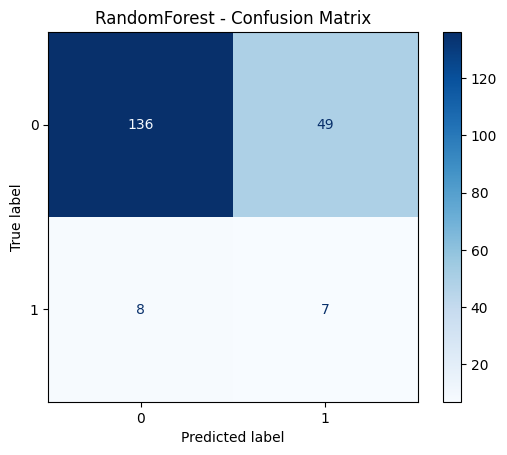

              precision    recall  f1-score   support

           0       0.94      0.74      0.83       185
           1       0.12      0.47      0.20        15

    accuracy                           0.71       200
   macro avg       0.53      0.60      0.51       200
weighted avg       0.88      0.71      0.78       200


===== XGBoost =====


/Users/tanyumin/miniconda3/envs/singhacks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:18:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best F1 threshold: 0.079


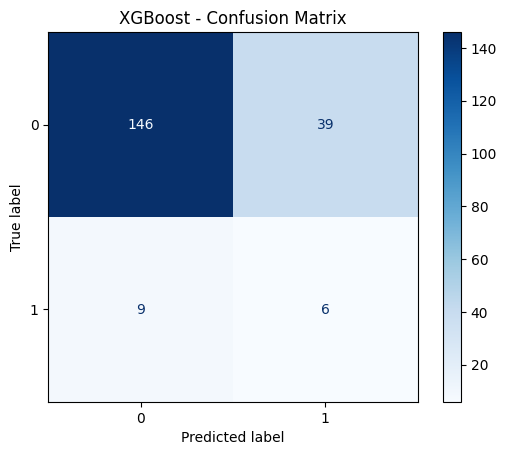

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       185
           1       0.13      0.40      0.20        15

    accuracy                           0.76       200
   macro avg       0.54      0.59      0.53       200
weighted avg       0.88      0.76      0.81       200


===== LightGBM =====
[LightGBM] [Info] Number of positive: 740, number of negative: 740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 1480, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

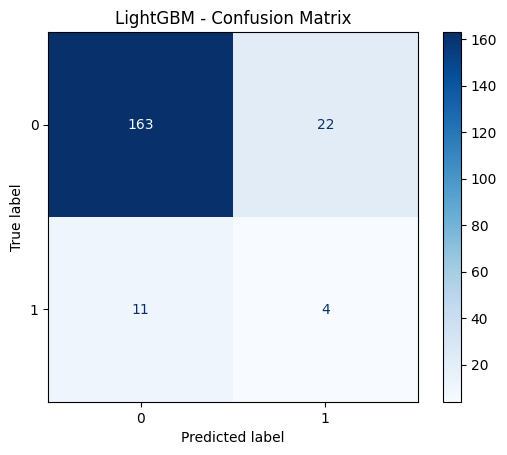

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       185
           1       0.15      0.27      0.20        15

    accuracy                           0.83       200
   macro avg       0.55      0.57      0.55       200
weighted avg       0.88      0.83      0.85       200



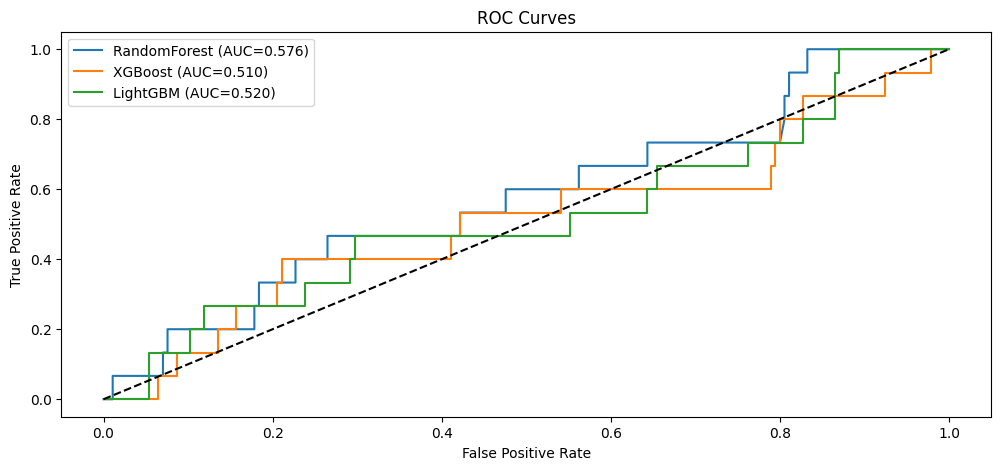

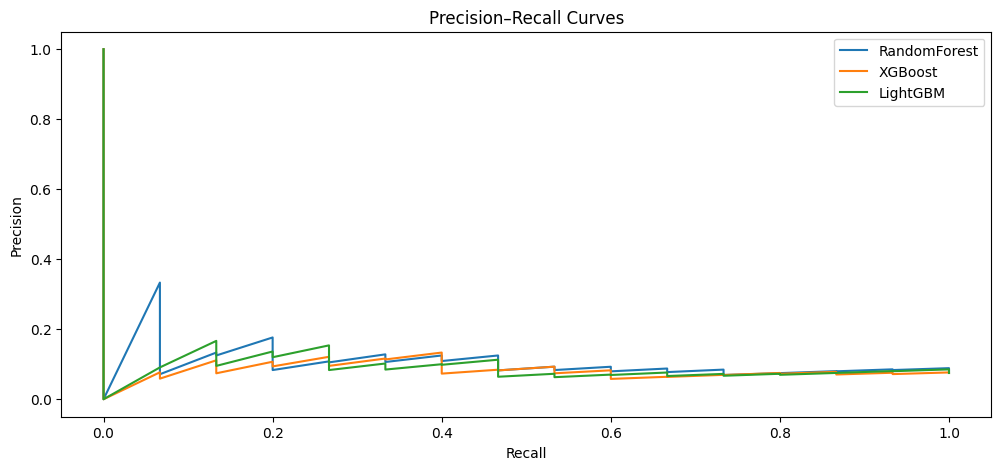


=== Summary ===


,Model,Best Threshold,AUC,Precision,Recall,F1
0,RandomForest,0.182102,0.575676,0.125000,0.466667,0.197183
2,LightGBM,0.002937,0.520360,0.153846,0.266667,0.195121
1,XGBoost,0.078924,0.510270,0.133333,0.400000,0.200000


In [34]:
# ==============================================
# 1️⃣ Setup
# ==============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve,
    precision_recall_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier


# ==============================================
# 2️⃣ Retrain Models with Improved Params
# ==============================================
neg, pos = np.bincount(y_train_res)
scale_ratio = neg / pos

models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=600,
        max_depth=20,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        use_label_encoder=False,
        scale_pos_weight=scale_ratio,
        learning_rate=0.05,
        n_estimators=600,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        objective="binary",
        is_unbalance=True,
        learning_rate=0.05,
        num_leaves=63,
        n_estimators=600,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
}


# ==============================================
# 3️⃣ Evaluate Each Model
# ==============================================
results = []

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_res, y_train_res)

    # Probability predictions
    y_proba = model.predict_proba(X_test)[:, 1]

    # Find best threshold by F1
    prec, rec, thr = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * prec * rec / (prec + rec + 1e-6)
    best_thr = thr[np.argmax(f1_scores)]
    print(f"Best F1 threshold: {best_thr:.3f}")

    y_pred = (y_proba >= best_thr).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # Metrics
    auc_roc = roc_auc_score(y_test, y_proba)
    precision = prec[np.argmax(f1_scores)]
    recall = rec[np.argmax(f1_scores)]
    f1_best = np.max(f1_scores)
    print(classification_report(y_test, y_pred))

    results.append({
        "Model": name,
        "Best Threshold": best_thr,
        "AUC": auc_roc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1_best
    })


# ==============================================
# 4️⃣ Plot ROC & PR Curves
# ==============================================
plt.figure(figsize=(12, 5))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.show()


# ==============================================
# 5️⃣ Summary Table
# ==============================================
summary = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print("\n=== Summary ===")
display(summary)


/Users/tanyumin/miniconda3/envs/singhacks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:21:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 740, number of negative: 740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 1480, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[14:21:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.
[14:21:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


[14:21:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[14:21:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[14:21:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Number of positive: 592, number of negative: 592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043430 seconds.
You can set `force_col_wise=true` to remo

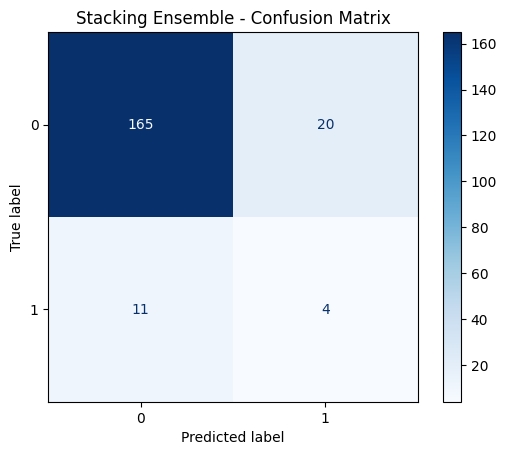

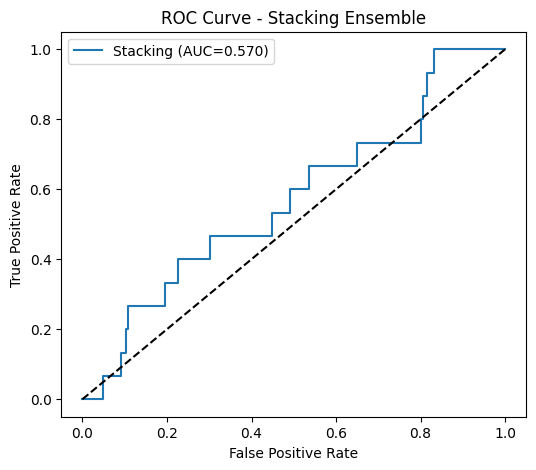

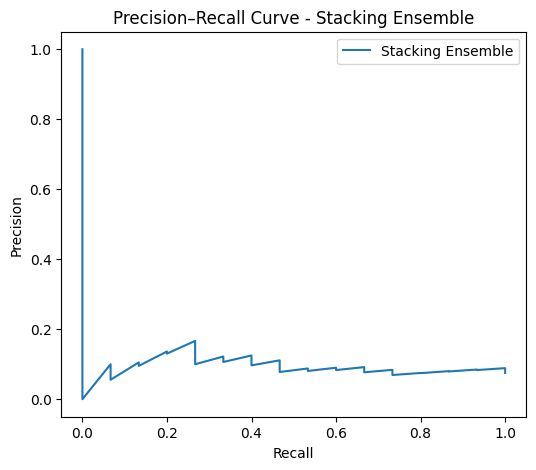

,AUC,Best Threshold,Best F1,Precision,Recall,TP,FP,FN,TN
0,0.56973,0.006273,0.205128,0.166667,0.266667,4,20,11,165


In [35]:
# ==============================================
# 1️⃣ Imports & Setup
# ==============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve
)

# Ensure reproducibility
np.random.seed(42)


# ==============================================
# 2️⃣ Define Base Models
# ==============================================
neg, pos = np.bincount(y_train_res)
scale_ratio = neg / pos

base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=600,
        max_depth=20,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        scale_pos_weight=scale_ratio,
        learning_rate=0.05,
        n_estimators=600,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )),
    ('lgb', LGBMClassifier(
        objective='binary',
        is_unbalance=True,
        learning_rate=0.05,
        num_leaves=63,
        n_estimators=600,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    ))
]


# ==============================================
# 3️⃣ Stacking Ensemble
# ==============================================
meta_model = LogisticRegression(max_iter=2000, class_weight='balanced')
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,               # internal cross-validation
    n_jobs=-1,
    passthrough=False,  # True if you want original features included
    stack_method='predict_proba'
)

stack_model.fit(X_train_res, y_train_res)

# ==============================================
# 4️⃣ Predict & Threshold Optimization
# ==============================================
y_proba = stack_model.predict_proba(X_test)[:, 1]

# Find best threshold for F1
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * prec * rec / (prec + rec + 1e-6)
best_thr = thr[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
print(f"Best F1 threshold: {best_thr:.3f}, F1: {best_f1:.3f}")

# Predict using tuned threshold
y_pred = (y_proba >= best_thr).astype(int)

# ==============================================
# 5️⃣ Evaluate & Visualize
# ==============================================
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.3f}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Stacking Ensemble - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Stacking (AUC={auc_score:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking Ensemble")
plt.legend()
plt.show()

# Precision–Recall Curve
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label="Stacking Ensemble")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - Stacking Ensemble")
plt.legend()
plt.show()

# Metrics summary
metrics = {
    "AUC": auc_score,
    "Best Threshold": best_thr,
    "Best F1": best_f1,
    "Precision": prec[np.argmax(f1_scores)],
    "Recall": rec[np.argmax(f1_scores)],
    "TP": cm[1,1],
    "FP": cm[0,1],
    "FN": cm[1,0],
    "TN": cm[0,0]
}
summary_df = pd.DataFrame([metrics])
display(summary_df)
